In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import cftime

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/isomip'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
SHELF_IC_FILE = 'MOM_Shelf_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
TOPO_FILE = '/INPUT/topoEdits.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [2]:
### Make "smooth" version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def smoothen_ocean1(filename):
    
    isf = xr.open_dataset(di + "/INPUT/Ocean1_3D.nc")
    sli = isf.thick.data[:,:]
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    #print(sli[7,85])
    
    sli[9,70]=(sli[9,69]+sli[9,71])/2  # y = 9
    sli[8,72]=(sli[8,71]+sli[8,73])/2  # y = 8
    sli[6,95]=(sli[6,94]+sli[6,96])/2 # y= 6
    sli[5,97]=(sli[5,96]+sli[5,98])/2 # y= 5
    sli[7,86]=(sli[7,84]+sli[7,88])/2 # y= 7
    sli[7,85]=(sli[7,84]+sli[7,86])/2 # y= 7
    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y= 7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y= 7
    
    sli[5,98]=(sli[5,96]+sli[5,100])/2 #y1=5
    sli[5,97]=(sli[5,96]+sli[5,98])/2  #y1=5

    sli[8,73]=sli[8,73]-(sli[8,73]-sli[8,74])/2 # y1=8
    sli[8,72]=(sli[8,71]+sli[8,73])/2 # y1=8
    sli[8,73]=(sli[8,72]+sli[8,74])/2 # y1 =8

    sli[7,87]=(sli[7,86]+sli[7,88])/2 # y1=7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,87]=(sli[7,85]+sli[7,89])/2 # y1 =7
    sli[7,88]=(sli[7,87]+sli[7,89])/2 # y1 =7
    sli[7,86]=(sli[7,85]+sli[7,87])/2 # y1 = 7

    sli[6,96]=(sli[6,95]+sli[6,97])/2 # y1=6
    sli[6,94]=(sli[6,95]+sli[6,93])/2 # y1 =6

    for jj in [4,3,2]:
       sli[jj,97]=(sli[jj,96]+sli[jj,98])/2 #y1=4
    
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=3
    #dat[4,97]=(dat[4,96]+dat[4,98])/2 #y1=2

    for jj in [10, 11,12,13,14,15,16,17,18,19]:
        sli[jj,70]=(sli[jj,71]+sli[jj,69])/2 #y1=10
    
    #dat[70]=(dat[71]+dat[69])/2 #y1=11
    #dat[70]=(dat[71]+dat[69])/2 #y1=12
    #dat[70]=(dat[71]+dat[69])/2 #y1=13
    #dat[70]=(dat[71]+dat[69])/2 #y1=14
    #dat[70]=(dat[71]+dat[69])/2 #y1=15
    #dat[70]=(dat[71]+dat[69])/2 #y1=16
    #dat[70]=(dat[71]+dat[69])/2 #y1=17
    #dat[70]=(dat[71]+dat[69])/2 #y1=18
    #dat[70]=(dat[71]+dat[69])/2 #y1=19
    
    new_shelf["thick"][:,:] = sli
    
    #print(sli[7,85])
    
    new_shelf.close()    

In [3]:
### Make symmetric version of ice shelf in_filename
### symmetrized version to be stored in out_filename
def symmetrize_iceshelf(in_filename, out_filename):
    
    isf = xr.open_dataset(in_filename)
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(out_filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    

In [4]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### (depends on MOM6 output in IC_FILE, ie. use after a run)
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [288]:
def make_topo_edits(yy,filename):
    new_topog = nc.Dataset(filename, "w", format="NETCDF4")
    new_topog.createDimension("nEdit", 40*yy)
    
    new_topog.createVariable("ni","int")
    new_topog.createVariable("nj","int")
    new_topog.createVariable("iEdit","int",("nEdit"))
    new_topog.createVariable("jEdit","int",("nEdit"))
    new_topog.createVariable("zEdit","f8",("nEdit"))

    new_topog["ni"][:] = 240
    new_topog["nj"][:] = 40
    
    new_topog["zEdit"][:] = np.zeros(40*yy)
    
    l = []
    a = np.arange(40)
    for i in range(yy):
        l.append(a)   
    new_topog["jEdit"][:] = np.array(l).flatten()
    
    l2 = []
    a2 = np.ones(40)
    for i in range(yy):
        l2.append(i*a2)
    new_topog["iEdit"][:] = np.array(l2).flatten()
    
    new_topog.close()

In [5]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [ ]:
#smoothen_ocean1(di + '/INPUT/tmp.nc')

In [ ]:
#symmetrize_iceshelf(di + '/INPUT/tmp.nc', di + ICE_SHELF_FILE)

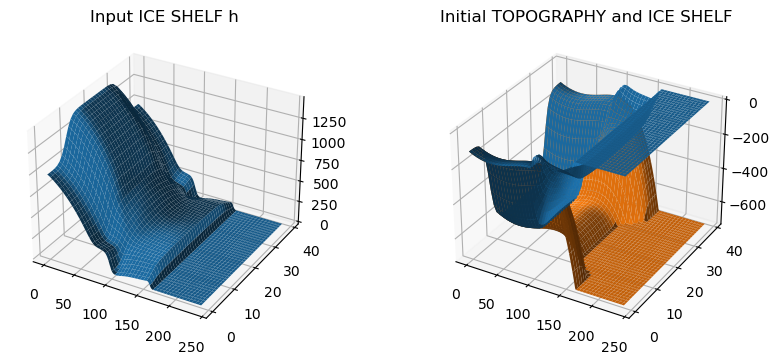

In [6]:
display_config()

In [ ]:
#make_thickness_file(di + THICKNESS_FILE)

### Plot output h,e,salt etc at chosen time

Text(0.5, 0.98, 'Run time = 1:00:00')

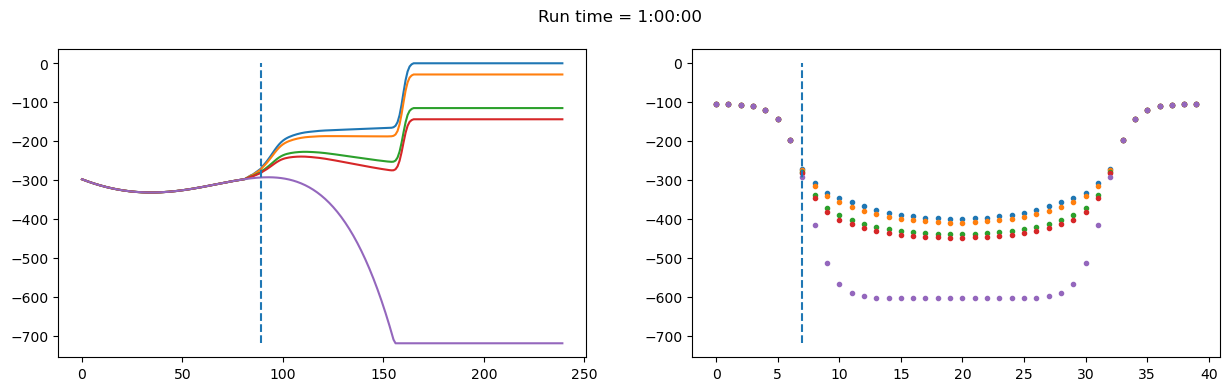

In [294]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
run_time = prog.coords["Time"].values[-1] - cftime.DatetimeJulian(1,1,1)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 4; yy=7; xx=89; ll = [0,1,zz,zz+1,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')
axes[0].vlines(xx, -720, 0, linestyles='dashed')
axes[1].vlines(yy, -720, 0, linestyles='dashed')

fig.suptitle("Run time = {}".format(run_time))

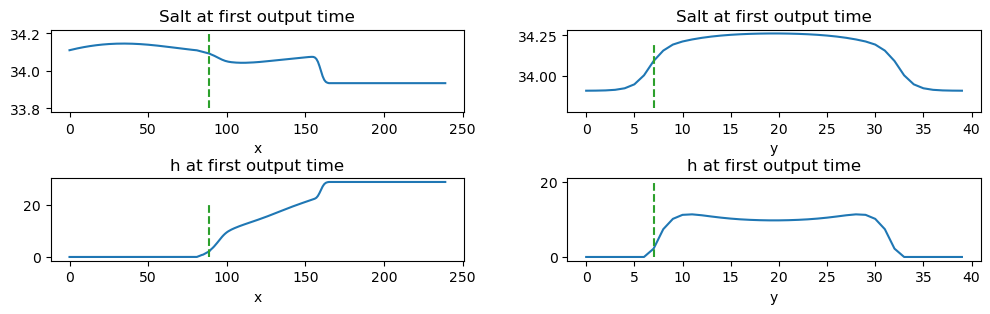

In [295]:
### Can see that the initial salt is "bad" with THICKNESS_CONFIG="ISOMIP" but "fixed" with THICKNESS_CONFIG="thickness_file" hack
ttt = 0; zzz = 4; yyy=7; xxx=89
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,3))
axes[0,0].plot(prog.salt.data[ttt][zzz][yyy,:])
axes[0,0].vlines(xxx, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("Salt at first output time")
axes[0,1].plot(prog.salt.data[ttt][zzz][:,xxx])
axes[0,1].vlines(yyy, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("Salt at first output time")
axes[1,0].plot(prog.h.data[ttt][zzz][yyy,:])
axes[1,0].set_xlabel("x")
axes[1,0].vlines(xxx, 0, 20, linestyles='dashed', colors='C2')
axes[1,0].set_title("h at first output time")
axes[1,1].plot(prog.h.data[ttt][zzz][:,xxx])
axes[1,1].vlines(yyy, 0, 20, linestyles='dashed', colors='C2')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("h at first output time")

plt.subplots_adjust(wspace = 0.25, hspace = 0.8)

In [296]:
np.nanmin(prog.h[0].data)

9.999998605144755e-05

In [297]:
t1 = -1
print(np.nanmax(prog.u.data[t1]), np.nanmin(prog.u.data[t1])) # 0.0012509557073082142 -0.0006301157530793094

0.00035468067997983894 -0.0023302742471173876


In [298]:
print(np.nanmax(prog.v.data[t1]), np.nanmin(prog.v.data[t1])) # 0.0012509557073082142 -0.0006301157530793094

0.0037212072134587214 -0.0037212072134587214


In [282]:
arr = prog.u.data[t1]
ind = np.unravel_index(np.nanargmin(arr),arr.shape)
print(arr[ind])
ind

-0.002330256933923516


(7, 8, 72)

np.nanmin(prog.e.data[0])

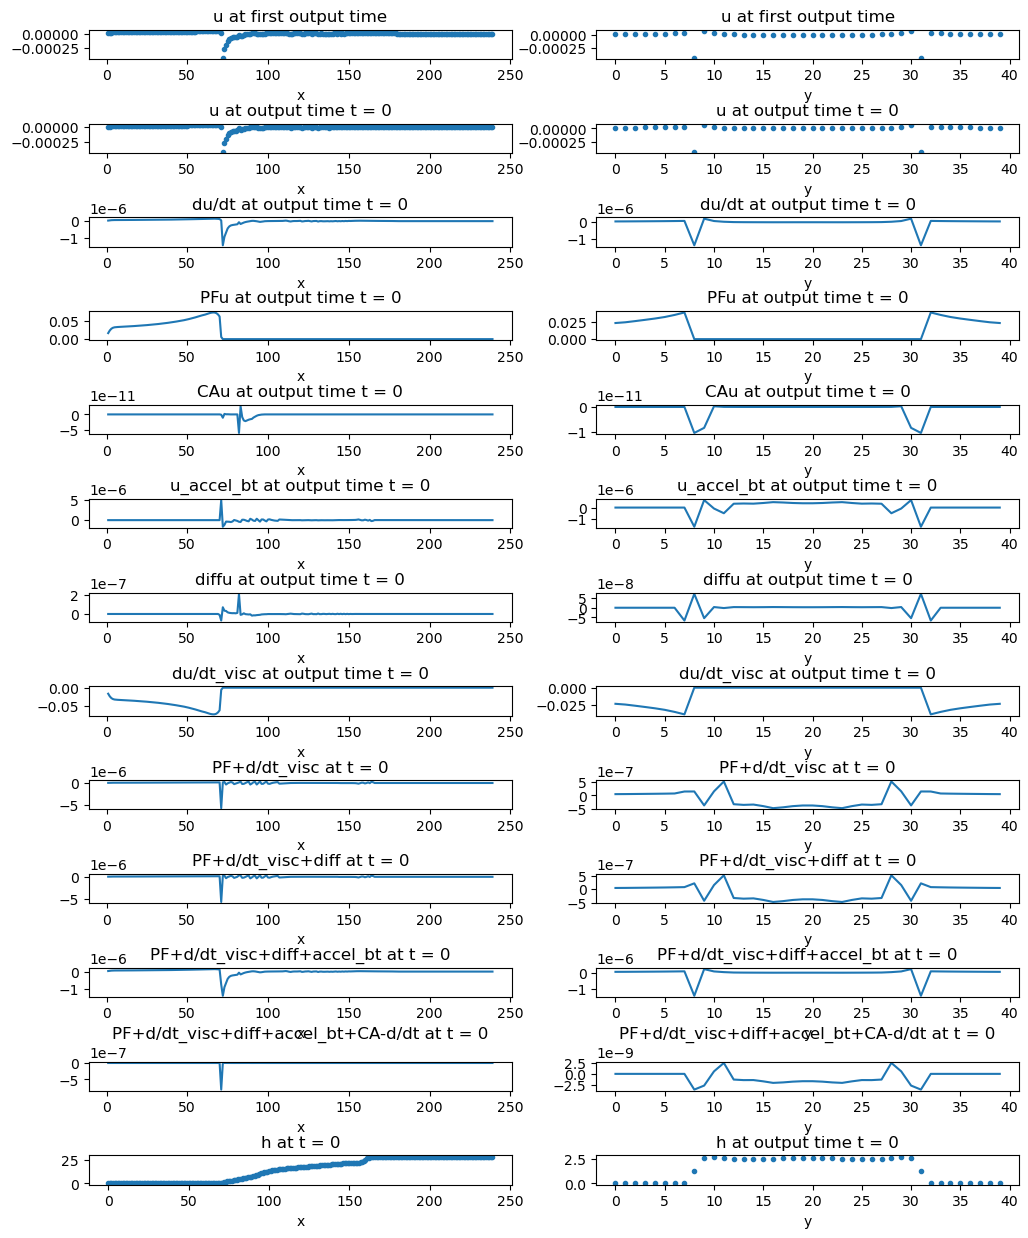

In [283]:
mo = xr.open_dataset(di + '/mom.nc')
fig,axes = plt.subplots(nrows =13, ncols = 2, figsize = (12,15))

tt=0; zz=7; yy=8; xx=72
showU = True
if (showU):
    u_or_v = "u"; prog_field = prog.u;
    mo_field1_desc = "du/dt"; mo_field1 = mo.dudt
    mo_field2_desc = "PFu"; mo_field2 = mo.PFu  
    mo_field3_desc = "CAu"; mo_field3 = mo.CAu   
    mo_field4_desc = "u_accel_bt"; mo_field4 = mo.u_accel_bt  
    mo_field5_desc = "diffu"; mo_field5 = mo.diffu
    mo_field6_desc = "du/dt_visc"; mo_field6 = mo.du_dt_visc
else:
    u_or_v = "v"; prog_field = prog.v;
    mo_field1_desc = "dv/dt"; mo_field1 = mo.dvdt
    mo_field2_desc = "PFv"; mo_field2 = mo.PFv  
    mo_field3_desc = "CAv"; mo_field3 = mo.CAv   
    mo_field4_desc = "v_accel_bt"; mo_field4 = mo.v_accel_bt 
    mo_field5_desc = "diffv"; mo_field5 = mo.diffv
    mo_field6_desc = "dv/dt_visc"; mo_field6 = mo.dv_dt_visc
    
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("{} at output time t = {}".format(u_or_v, tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("{} at output time t = {}".format(u_or_v,tt))
axes[2,0].plot(mo_field1[tt][zz].data[yy,:])
#axes[2,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("{} at output time t = {}".format(mo_field1_desc,tt))
axes[2,1].plot(mo_field1[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("{} at output time t = {}".format(mo_field1_desc, tt))
axes[3,0].plot(mo_field2[tt][zz].data[yy,:])
#axes[3,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("{} at output time t = {}".format(mo_field2_desc,tt))
axes[3,1].plot(mo_field2[tt][zz].data[:,xx])
axes[3,1].set_xlabel("y")
axes[3,1].set_title("{} at output time t = {}".format(mo_field2_desc, tt))
axes[4,0].plot(mo_field3[tt][zz].data[yy,:])
#axes[4,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[4,0].set_xlabel("x")
axes[4,0].set_title("{} at output time t = {}".format(mo_field3_desc,tt))
axes[4,1].plot(mo_field3[tt][zz].data[:,xx])
axes[4,1].set_xlabel("y")
axes[4,1].set_title("{} at output time t = {}".format(mo_field3_desc, tt))
axes[5,0].plot(mo_field4[tt].data[yy,:])
#axes[5,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[5,0].set_xlabel("x")
axes[5,0].set_title("{} at output time t = {}".format(mo_field4_desc,tt))
axes[5,1].plot(mo_field4[tt].data[:,xx])
axes[5,1].set_xlabel("y")
axes[5,1].set_title("{} at output time t = {}".format(mo_field4_desc, tt))
axes[6,0].plot(mo_field5[tt][zz].data[yy,:])
#axes[6,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[6,0].set_xlabel("x")
axes[6,0].set_title("{} at output time t = {}".format(mo_field5_desc,tt))
axes[6,1].plot(mo_field5[tt][zz].data[:,xx])
axes[6,1].set_xlabel("y")
axes[6,1].set_title("{} at output time t = {}".format(mo_field5_desc, tt))
axes[7,0].plot(mo_field6[tt][zz].data[yy,:])
#axes[7,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[7,0].set_xlabel("x")
axes[7,0].set_title("{} at output time t = {}".format(mo_field6_desc,tt))
axes[7,1].plot(mo_field6[tt][zz].data[:,xx])
axes[7,1].set_xlabel("y")
axes[7,1].set_title("{} at output time t = {}".format(mo_field6_desc, tt))
axes[8,0].plot(mo_field2[tt][zz].data[yy,:]+mo_field6[tt][zz].data[yy,:])
#axes[8,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[8,0].set_xlabel("x")
axes[8,0].set_title("{} at t = {}".format("PF+d/dt_visc",tt))
axes[8,1].plot(mo_field2[tt][zz].data[:,xx]+mo_field6[tt][zz].data[:,xx])
axes[8,1].set_xlabel("y")
axes[8,1].set_title("{} at t = {}".format("PF+d/dt_visc", tt))
axes[9,0].plot(mo_field2[tt][zz].data[yy,:]+mo_field6[tt][zz].data[yy,:]
              +mo_field5[tt][zz].data[yy,:])
#axes[9,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[9,0].set_xlabel("x")
axes[9,0].set_title("{} at t = {}".format("PF+d/dt_visc+diff",tt))
axes[9,1].plot(mo_field2[tt][zz].data[:,xx]+mo_field6[tt][zz].data[:,xx]
              +mo_field5[tt][zz].data[:,xx])
axes[9,1].set_xlabel("y")
axes[9,1].set_title("{} at t = {}".format("PF+d/dt_visc+diff", tt))
axes[10,0].plot(mo_field2[tt][zz].data[yy,:]+mo_field6[tt][zz].data[yy,:]
              +mo_field5[tt][zz].data[yy,:]+mo_field4[tt].data[yy,:])
#axes[10,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[10,0].set_xlabel("x")
axes[10,0].set_title("{} at t = {}".format("PF+d/dt_visc+diff+accel_bt",tt))
axes[10,1].plot(mo_field2[tt][zz].data[:,xx]+mo_field6[tt][zz].data[:,xx]
              +mo_field5[tt][zz].data[:,xx]+mo_field4[tt].data[:,xx])
axes[10,1].set_xlabel("y")
axes[10,1].set_title("{} at t = {}".format("PF+d/dt_visc+diff+accel_bt", tt))
axes[11,0].plot(mo_field2[tt][zz].data[yy,:]+mo_field6[tt][zz].data[yy,:]
              +mo_field5[tt][zz].data[yy,:]+mo_field4[tt].data[yy,:]
               +mo_field3[tt][zz].data[yy,:]-mo_field1[tt][zz].data[yy,:])
#axes[11,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[11,0].set_xlabel("x")
axes[11,0].set_title("{} at t = {}".format("PF+d/dt_visc+diff+accel_bt+CA-d/dt",tt))
axes[11,1].plot(mo_field2[tt][zz].data[:,xx]+mo_field6[tt][zz].data[:,xx]
              +mo_field5[tt][zz].data[:,xx]+mo_field4[tt].data[:,xx]
               +mo_field3[tt][zz].data[:,xx]-mo_field1[tt][zz].data[:,xx])
axes[11,1].set_xlabel("y")
axes[11,1].set_title("{} at t = {}".format("PF+d/dt_visc+diff+accel_bt+CA-d/dt", tt))
axes[12,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[12,0].set_xlabel("x")
axes[12,0].set_title("h at t = {}".format(tt))
axes[12,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[12,1].set_xlabel("y")
axes[12,1].set_title("h at output time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.2, hspace = 2.2)

mo.close()

In [ ]:
fc = xr.open_dataset(di + '/forcing.nc')

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,1.5))

tt=-1; yy=8; xx=94

#fc_field = fc.taux
#fc_field = fc.tauy
#fc_field = fc.ustar
#fc_field = fc.PRCmE
fc_field = fc.p_surf

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0].plot(fc_field[tt].data[yy,:],'.')
axes[0].set_xlabel("x")
axes[0].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting
axes[1].plot(fc_field[tt].data[:,xx],'.')
axes[1].set_xlabel("y")
axes[1].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting

In [ ]:
! cat input.nml | tail

In [ ]:
! cat diag_table | head

In [ ]:
! cat MOM_override | tail -n 25

In [ ]:
ice=xr.open_dataset(di + '/' + "ice.nc")
ice

In [ ]:
np.unique(np.concatenate((np.unique(ice.mass_flux[-1].data),
                          np.unique(ice.melt_rate[-1].data),
                         #np.unique(ice.thermal_driving[-1].data),
                         np.unique(ice.haline_driving[-1].data),
                         #np.unique(ice.sbdry[-1].data),
                         #np.unique(ice.u_ml[-1].data),
                         #np.unique(ice.v_ml[-1].data),
                         np.unique(ice.exch_vel_s[-1].data),
                         np.unique(ice.exch_vel_t[-1].data),
                         np.unique(ice.tfreeze[-1].data),
                         np.unique(ice.tflux_shelf[-1].data),
                         #np.unique(ice.ustar_shelf[-1].data)
                         )))

plt.plot(prog.h[0][0].data[8,:],'.')
#plt.xlim([60,90])
#plt.ylim([0,8])

In [ ]:
iss=xr.open_dataset(di + ICE_SHELF_FILE)

fig,axes = plt.subplots(nrows = 3, ncols = 1, figsize = (6,6))

y1=7
dat = iss.thick[y1].data

#dat[98]=(dat[96]+dat[100])/2 #y1=5
#dat[97]=(dat[96]+dat[98])/2  #y1=5

#dat[73]=dat[73]-(dat[73]-dat[74])/2 # y1=8
#dat[72]=(dat[71]+dat[73])/2 # y1=8
#dat[73]=(dat[72]+dat[74])/2 # y1 =8

#dat[87]=(dat[86]+dat[88])/2 # y1=7
#dat[88]=(dat[87]+dat[89])/2 # y1 =7
#dat[87]=(dat[85]+dat[89])/2 # y1 =7
#dat[88]=(dat[87]+dat[89])/2 # y1 =7
#dat[86]=(dat[85]+dat[87])/2 # y1 = 7

#dat[96]=(dat[95]+dat[97])/2 # y1=6
#dat[94]=(dat[95]+dat[93])/2 # y1 =6

#dat[97]=(dat[96]+dat[98])/2 #y1=4

#dat[97]=(dat[96]+dat[98])/2 #y1=3

#dat[97]=(dat[96]+dat[98])/2 #y1=2

#dat[70]=(dat[71]+dat[69])/2 #y1=10

#dat[70]=(dat[71]+dat[69])/2 #y1=11

#dat[70]=(dat[71]+dat[69])/2 #y1=12

#dat[70]=(dat[71]+dat[69])/2 #y1=13

#dat[70]=(dat[71]+dat[69])/2 #y1=14

#dat[70]=(dat[71]+dat[69])/2 #y1=15

#dat[70]=(dat[71]+dat[69])/2 #y1=16

#dat[70]=(dat[71]+dat[69])/2 #y1=17

#dat[70]=(dat[71]+dat[69])/2 #y1=18

#dat[70]=(dat[71]+dat[69])/2 #y1=19

#axes[0].set_xlim([80,90])
#axes[0].set_ylim([300,360])
#axes[1].set_xlim([80,90])
#axes[2].set_xlim([90,110])

axes[0].plot(dat, '.')
axes[1].plot(np.gradient(dat))
axes[1].vlines(xx, -40, 0, linestyles='dashed', colors='C2')
axes[2].plot(np.gradient(np.gradient(dat)))
axes[2].vlines(xx, -10, 10, linestyles='dashed', colors='C2')

In [ ]:
mo

In [34]:
## check initial salt is linear

ic=xr.open_dataset(di + "/" +IC_FILE)

S_TOP = 33.8
S_BOTTOM = 34.55
MAXIMUM_DEPTH = 720.0

eta = ic.eta[0].data[0]
s=(eta - ic.h[0].data.cumsum(axis=0) + ic.h[0].data/2)*(S_BOTTOM-S_TOP)/(-MAXIMUM_DEPTH) + S_TOP

np.unique(ic.Salt[0].data-s)

array([-7.10542736e-15,  0.00000000e+00,  7.10542736e-15])